In [1]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Permute, Activation, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-03-23 14:55:28.593917: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 14:55:30.016330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 14:55:30.689597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16843 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


In [2]:
img_x, img_y = (576, 576)
dx = 48
filelst = os.listdir(r'DRIVE/training/images/')
filelst = ['DRIVE/training/images/'+v for v in filelst]
imgs = [cv2.imread(file) for file in filelst]
filelst = os.listdir(r'DRIVE/training/1st_manual/')
filelst = ['DRIVE/training/1st_manual/'+v for v in filelst]
manuals = [np.asarray(Image.open(file)) for file in filelst]
imgs = [cv2.resize(v,(img_x, img_y)) for v in imgs]
manuals = [cv2.resize(v,(img_x, img_y)) for v in manuals]
X_train = np.array(imgs)  
Y_train = np.array(manuals)
X_train = X_train.astype('float32')/255.
Y_train = Y_train.astype('float32')/255.
X_train = X_train[...,1] # the G channel
X_train = np.array([[X_train[:,v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx,dx)[:,np.newaxis,...]
Y_train = np.array([[Y_train[:,v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx*dx)[...,np.newaxis]
temp = 1-Y_train
Y_train = np.concatenate([Y_train,temp],axis=2)

In [3]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


def conv_block(input_tensor, num_filters):
    """构造一个简单的卷积块，包含两个卷积层"""
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', data_format='channels_first')(input_tensor)
    x = Dropout(0.2)(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same', data_format='channels_first')(x)
    return x

def unet_pp(n_ch, patch_height, patch_width):
    inputs = Input(shape=(n_ch, patch_height, patch_width))

    # 编码路径
    x00 = conv_block(inputs, 32)
    p0 = MaxPooling2D((2, 2))(x00)
    x10 = conv_block(p0, 64)
    p1 = MaxPooling2D((2, 2))(x10)
    x20 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(x20)
    x30 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(x30)
    x40 = conv_block(p3, 512) # 最底层
    
    # wtf 纯手写中间层啊，草
    x40_up = UpSampling2D(size=(2, 2))(x40)
    x40_up = concatenate([x30,x40_up],axis=1)
    x31 = conv_block(x40_up, 256)
    
    x30_up = UpSampling2D(size=(2, 2))(x30)
    x30_up = concatenate([x20,x30_up],axis=1)
    x21 = conv_block(x30_up, 128)
    
    x20_up = UpSampling2D(size=(2, 2))(x20)
    x20_up = concatenate([x10,x20_up],axis=1)
    x11 = conv_block(x20_up, 64)
    
    x10_up = UpSampling2D(size=(2, 2))(x10)
    x10_up = concatenate([x00,x10_up],axis=1)
    x01 = conv_block(x10_up, 32)
    
    x31_up = UpSampling2D(size=(2, 2))(x31)
    x31_up = concatenate([x21,x31_up],axis=1)
    x31_up = concatenate([x20,x31_up],axis=1)
    x22 = conv_block(x31_up, 128)
    
    x21_up = UpSampling2D(size=(2, 2))(x21)
    x21_up = concatenate([x11,x21_up],axis=1)
    x21_up = concatenate([x10,x21_up],axis=1)
    x12 = conv_block(x21_up, 64)
    
    x11_up = UpSampling2D(size=(2, 2))(x11)
    x11_up = concatenate([x01,x11_up],axis=1)
    x11_up = concatenate([x00,x11_up],axis=1)
    x02 = conv_block(x11_up, 32)
    
    x22_up = UpSampling2D(size=(2, 2))(x22)
    x22_up = concatenate([x12,x22_up],axis=1)
    x22_up = concatenate([x11,x22_up],axis=1)
    x22_up = concatenate([x10,x22_up],axis=1)
    x13 = conv_block(x22_up, 64)
    
    x12_up = UpSampling2D(size=(2, 2))(x12)
    x12_up = concatenate([x02,x12_up],axis=1)
    x12_up = concatenate([x01,x12_up],axis=1)
    x12_up = concatenate([x00,x12_up],axis=1)
    x03 = conv_block(x12_up, 32)
    
    x13_up = UpSampling2D(size=(2, 2))(x13)
    x13_up = concatenate([x03,x13_up],axis=1)
    x13_up = concatenate([x02,x13_up],axis=1)
    x13_up = concatenate([x01,x13_up],axis=1)
    x13_up = concatenate([x00,x13_up],axis=1)
    x04 = conv_block(x13_up, 32)
    
    # 最终层
    final_1 = Conv2D(2,(1,1),activation='relu',padding='same',data_format='channels_first')(x01)
    final_1 = Reshape((2,patch_height*patch_width))(final_1)
    final_1 = Permute((2,1))(final_1)
    final_1 = Activation('softmax')(final_1)
    
    final_2 = Conv2D(2,(1,1),activation='relu',padding='same',data_format='channels_first')(x02)
    final_2 = Reshape((2,patch_height*patch_width))(final_2)
    final_2 = Permute((2,1))(final_2)
    final_2 = Activation('softmax')(final_2)
    
    final_3 = Conv2D(2,(1,1),activation='relu',padding='same',data_format='channels_first')(x03)
    final_3 = Reshape((2,patch_height*patch_width))(final_3)
    final_3 = Permute((2,1))(final_3)
    final_3 = Activation('softmax')(final_3)
    
    final_4 = Conv2D(2,(1,1),activation='relu',padding='same',data_format='channels_first')(x04)
    final_4 = Reshape((2,patch_height*patch_width))(final_4)
    final_4 = Permute((2,1))(final_4)
    final_4 = Activation('softmax')(final_4)
    
    final = [final_1, final_2, final_3, final_4]
    
    # Unet++ L4到L1需要manual modification。
    model = Model(inputs=inputs, outputs=final_4)

    return model

X_train shape: (2880, 1, 48, 48)
Y_train shape: (2880, 2304, 2)


In [4]:
# 以下是训练L4的

In [5]:
model = unet_pp(X_train.shape[1],X_train.shape[2],X_train.shape[3])
model.summary()

# mode = 'max'
checkpointer = ModelCheckpoint(filepath='best_weights.h5', verbose=1, monitor='val_acc', mode='auto', save_best_only=True)
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

2024-03-23 14:55:55.646412: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16843 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 48, 48)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 48, 48)   320         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32, 48, 48)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 48, 48)   9248        ['dropout[0][0]']                
                                                                                              

/root/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=100, verbose=2, shuffle=True, validation_split=0.2, callbacks=[checkpointer])

# 获取训练集和验证集的损失和准确率
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/100


2024-03-23 14:56:04.748107: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


36/36 - 10s - loss: 0.3623 - accuracy: 0.8867 - val_loss: 0.1850 - val_accuracy: 0.9325 - 10s/epoch - 287ms/step
Epoch 2/100
36/36 - 3s - loss: 0.2772 - accuracy: 0.9093 - val_loss: 0.1829 - val_accuracy: 0.9325 - 3s/epoch - 92ms/step
Epoch 3/100
36/36 - 3s - loss: 0.2692 - accuracy: 0.9093 - val_loss: 0.1768 - val_accuracy: 0.9325 - 3s/epoch - 96ms/step
Epoch 4/100
36/36 - 3s - loss: 0.2488 - accuracy: 0.9127 - val_loss: 0.1572 - val_accuracy: 0.9441 - 3s/epoch - 96ms/step
Epoch 5/100
36/36 - 3s - loss: 0.2020 - accuracy: 0.9328 - val_loss: 0.1543 - val_accuracy: 0.9459 - 3s/epoch - 97ms/step
Epoch 6/100
36/36 - 3s - loss: 0.1800 - accuracy: 0.9388 - val_loss: 0.1293 - val_accuracy: 0.9554 - 3s/epoch - 95ms/step
Epoch 7/100
36/36 - 3s - loss: 0.1622 - accuracy: 0.9442 - val_loss: 0.1056 - val_accuracy: 0.9620 - 3s/epoch - 93ms/step
Epoch 8/100
36/36 - 3s - loss: 0.1504 - accuracy: 0.9471 - val_loss: 0.0885 - val_accuracy: 0.9679 - 3s/epoch - 93ms/step
Epoch 9/100
36/36 - 3s - loss: 0.

In [7]:
imgs = cv2.imread(r'DRIVE/test/images/01_test.tif')[...,1] #the G channel
imgs = cv2.resize(imgs,(img_x, img_y))
manuals = np.asarray(Image.open(r'DRIVE/test/1st_manual/01_manual1.gif'))
X_test = imgs.astype('float32')/255.
Y_test = manuals.astype('float32')/255.
X_test = np.array([[X_test[v*dx:(v+1)*dx, vv*dx:(vv+1)*dx] for v in range(img_y//dx)] for vv in range(img_x//dx)]).reshape(-1,dx,dx)[:,np.newaxis,...]
# model.load_weights('best_weights.h5')
Y_pred = model.predict(X_test)
Y_pred = Y_pred[...,0].reshape(img_x//dx,img_y//dx,dx,dx)
Y_pred = [Y_pred[:,v,...] for v in range(img_x//dx)]
Y_pred = np.concatenate(np.concatenate(Y_pred,axis=1),axis=1)
Y_pred = cv2.resize(Y_pred,(Y_test.shape[1], Y_test.shape[0]))

5/5 [==============================] - 1s 90ms/step


In [9]:
plt.figure(figsize=(6,6))
plt.imshow(Y_pred)
plt.savefig('unetpp_L4_predicted_image.png')  # 保存预测的图像
plt.close()  # 关闭当前图形以释放内存

plt.figure(figsize=(6,6))
plt.imshow(Y_test)
plt.savefig('unetpp_L4_ground_truth_image.png')  # 保存真实的图像
plt.close()  # 关闭当前图形以释放内存

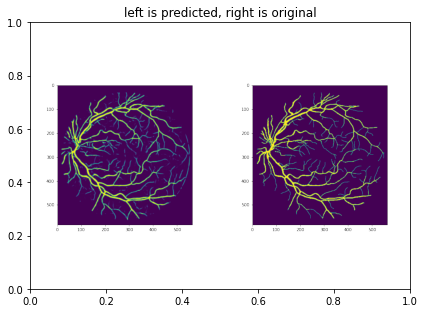

In [10]:
import matplotlib.pyplot as plt

image1 = plt.imread('unetpp_L4_predicted_image.png')
image2 = plt.imread('unetpp_L4_ground_truth_image.png')

fig = plt.figure()
plt.title("left is predicted, right is original")

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image1)
ax1.axis('off')  # 关闭坐标轴

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image2)
ax2.axis('off')  # 关闭坐标轴

plt.tight_layout()

plt.savefig('merged_unetpp_L4_image.png')
plt.show()

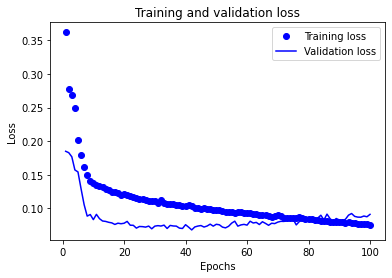

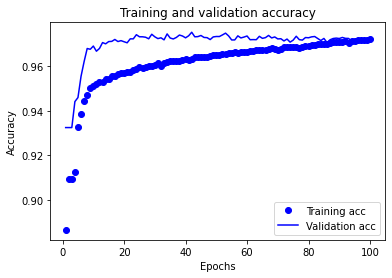

In [11]:
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('unetpp_L4_loss.png')
plt.show()

plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('unetpp_L4_acc.png')
plt.show()